In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices
from shapley.tests import ProductGaussian, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results, plot_error, plot_var, plot_cover

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True

In [2]:
dim = 3
corr = 0.
Model = AdditiveGaussian

beta = None
model = Model(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
theta = [0., 0., corr]
model.copula_parameters = theta
    
true_results = {
    'Shapley': model.shapley_indices,
    'First Sobol': model.first_sobol_indices,
    'Total Sobol': model.total_sobol_indices
}

In [1]:
from math import factorial

n_boot = 1000
n_run = 100

method = 'exact'
n_var = 10000
n_perms = None

all_n_axes = [3, 9, 18]
n_n_axes = len(all_n_axes)

n_n_ticks = 30
min_n_ticks = factorial(dim) * all_n_axes[-1] * 1
max_n_ticks = 3000

all_n_ticks = np.logspace(np.log10(min_n_ticks), np.log10(max_n_ticks), n_n_ticks, base=10, dtype=int)
all_n_ticks = np.unique(all_n_ticks)
n_n_ticks = len(all_n_ticks)

NameError: name 'dim' is not defined

In [5]:
%%time

all_shapley_results = np.zeros((n_n_ticks, n_n_axes, n_run, dim, n_boot))
all_first_results = np.zeros((n_n_ticks, n_n_axes, n_run, dim, n_boot))
all_total_results = np.zeros((n_n_ticks, n_n_axes, n_run, dim, n_boot))

all_shapley_results_SE = np.zeros((n_n_ticks, n_n_axes, n_run, dim))
all_first_results_SE = np.zeros((n_n_ticks, n_n_axes, n_run, dim))
all_total_results_SE = np.zeros((n_n_ticks, n_n_axes, n_run, dim))

for i_ticks, n_ticks in enumerate(all_n_ticks):
    for i_axes, n_axes in enumerate(all_n_axes):
        n_inner = n_axes
        n_outer = int(n_ticks / (n_inner * factorial(dim)))
        print('N_ticks:', n_ticks, 'N_axes:', n_axes)
        
        for i_run in range(n_run):            
            shapley = ShapleyIndices(model.input_distribution)
            shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=int(n_outer), n_inner=int(n_inner))
            shapley_results = shapley.compute_indices(n_boot=n_boot)
            
            all_shapley_results[i_ticks, i_axes, i_run] = shapley_results.full_shapley_indices
            all_first_results[i_ticks, i_axes, i_run] = shapley_results.full_first_indices
            all_total_results[i_ticks, i_axes, i_run] = shapley_results.full_total_indices            
                        
            all_shapley_results_SE[i_ticks, i_axes, i_run] = shapley_results.shapley_indices_SE
            all_first_results_SE[i_ticks, i_axes, i_run] = shapley_results.first_indices
            all_total_results_SE[i_ticks, i_axes, i_run] = shapley_results.total_indices_SE

N_ticks: 108 N_axes: 3
N_ticks: 108 N_axes: 9
N_ticks: 108 N_axes: 18
N_ticks: 121 N_axes: 3
N_ticks: 121 N_axes: 9
N_ticks: 121 N_axes: 18
N_ticks: 135 N_axes: 3
N_ticks: 135 N_axes: 9
N_ticks: 135 N_axes: 18
N_ticks: 152 N_axes: 3
N_ticks: 152 N_axes: 9
N_ticks: 152 N_axes: 18
N_ticks: 170 N_axes: 3
N_ticks: 170 N_axes: 9
N_ticks: 170 N_axes: 18
N_ticks: 191 N_axes: 3
N_ticks: 191 N_axes: 9
N_ticks: 191 N_axes: 18
N_ticks: 214 N_axes: 3
N_ticks: 214 N_axes: 9
N_ticks: 214 N_axes: 18
N_ticks: 240 N_axes: 3
N_ticks: 240 N_axes: 9
N_ticks: 240 N_axes: 18
N_ticks: 270 N_axes: 3
N_ticks: 270 N_axes: 9
N_ticks: 270 N_axes: 18
N_ticks: 303 N_axes: 3
N_ticks: 303 N_axes: 9
N_ticks: 303 N_axes: 18
N_ticks: 339 N_axes: 3
N_ticks: 339 N_axes: 9
N_ticks: 339 N_axes: 18
N_ticks: 381 N_axes: 3
N_ticks: 381 N_axes: 9
N_ticks: 381 N_axes: 18
N_ticks: 427 N_axes: 3
N_ticks: 427 N_axes: 9
N_ticks: 427 N_axes: 18
N_ticks: 479 N_axes: 3
N_ticks: 479 N_axes: 9
N_ticks: 479 N_axes: 18
N_ticks: 537 N_axes:

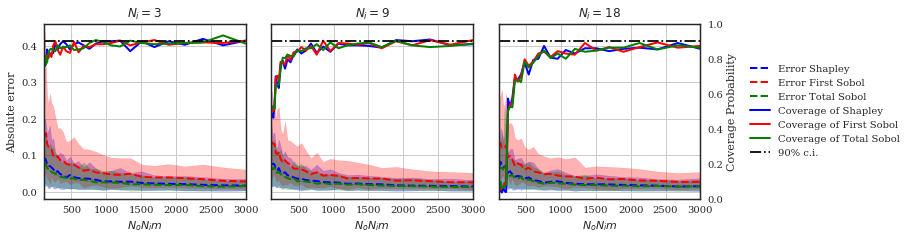

In [7]:
# Coverage probability
ci_prob = 0.10
error_type = 'absolute'
logscale = False
name = 'N_o N_i m'
savefigs = True
ci_method = 'bootstrap'

do_cover = False
if n_boot > 1 or method == 'random':
    do_cover = True

if name == 'N_i':
    x_ticks = all_n_inner
    x_axes = all_n_outer
    name_axes = 'N_o'
    axis = 0
elif name == 'N_o':
    x_ticks = all_n_outer
    x_axes = all_n_inner
    name_axes = 'N_i'
    axis = 1
elif name == 'N_o N_i':
    x_ticks = all_n_ticks
    x_axes = all_n_axes
    name_axes = 'N_i'
    axis = 1
elif name == 'N_o N_i m':
    x_ticks = all_n_ticks
    x_axes = all_n_axes
    name_axes = 'N_i'
    axis = 1

n_col = len(x_axes)
fig, axes = plt.subplots(1, n_col, figsize=(2.5*n_col+3, 3.5), sharex=True, sharey=True) 
    
axes = [axes] if n_col == 1 else axes

for i_ax, (N, ax_err) in enumerate(zip(x_axes, axes)):
    
    # Chose the associated result
    results = {
        'Shapley': all_shapley_results.take(i_ax, axis=axis),
        'First Sobol': all_first_results.take(i_ax, axis=axis),
        'Total Sobol': all_total_results.take(i_ax, axis=axis)
    }
            
    plot_error(results, true_results, x_ticks, ax=ax_err, error_type=error_type, logscale=logscale)

    ax_cov = ax_err.twinx()
    ax_cov.set_ylim(0., 1.)
    if do_cover:
        plot_cover(results, true_results, x_ticks, ax=ax_cov, ci_prob=ci_prob, ci_method=ci_method)
        if i_ax < n_col - 1:
            plt.setp(ax_cov.get_yticklabels(), visible=False)
            ax_cov.set_ylabel('')
            ax_cov.set_yticks([])
            
    if i_ax > 0:
        plt.setp(ax_err.get_yticklabels(), visible=False)
        ax_err.set_ylabel('')
        
    ax_err.set_xlabel('$%s$' % (name))
    ax_err.grid()
    ax_err.set_title('$%s = %d$' % (name_axes, N))
    
    if i_ax == n_col-1:
        h_err, l_err = ax_err.get_legend_handles_labels()
        h_cov, l_cov = ax_cov.get_legend_handles_labels()
        ax_err.legend(h_err + h_cov, l_err + l_cov, loc='center left', 
                          bbox_to_anchor=(1.2, 0.5))

fig.tight_layout()
if savefigs:
    figname = './output/%s_precision_dim_%d_%s_nboot_%d' % (Model.__name__, dim, method, n_boot)
    figname += '%s_%s' % (name, ci_method)
    figname += '_n_ticks_%d_n_naxes_%d_rho_%.2f_Nv_%d_maxNticks_%d_nrun_%d_%s' %\
        (n_n_ticks, n_n_axes, corr, n_var, max_n_ticks, n_run, error_type)
    fig.savefig(figname + '.pdf', bbox_inches='tight')
    fig.savefig(figname + '.png', bbox_inches='tight')